In [169]:
import numpy as np
import tensorflow as tf
from stochastic.processes.continuous import FractionalBrownianMotion
#import fbm
#from fbm import mbm,mgn,times
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import math
import pandas as pd
%matplotlib notebook

pi = math.pi

In [30]:
def gen_fbm_track(ntimes, hurst_exp, initial_position=[0,0,0]):

    fbm = FractionalBrownianMotion(hurst=hurst_exp,t=1,rng=None)
    x = fbm.sample(ntimes)
    y = fbm.sample(ntimes)
    z = fbm.sample(ntimes)
    
    r = np.sqrt((np.amax(x)-np.amin(x))**2 + (np.amax(y)-np.amin(y))**2 + (np.amax(z)-np.amin(z))**2) 
    
    dx = (x[1:]-x[0:-1])/(np.amax(x)-np.amin(x))#r
    dy = (y[1:]-y[0:-1])/(np.amax(y)-np.amin(y))#r
    dz = (z[1:]-z[0:-1])/(np.amax(z)-np.amin(z))#r
    
    #dx = (x[1:]-x[0:-1])*hurst_exp
    #dy = (y[1:]-y[0:-1])*hurst_exp
    #dz = (z[1:]-z[0:-1])*hurst_exp
    
    x_norm = np.append(np.array([0]),np.cumsum(dx))
    y_norm = np.append(np.array([0]),np.cumsum(dy))
    z_norm = np.append(np.array([0]),np.cumsum(dz))

    x0, y0, z0 = initial_position
    #x, y, z = x+x0,y+y0,z+z0#
    x, y, z = x_norm+x0, y_norm+y0, z_norm+z0
        
    return x, y, z

def track_until_reflection(xs, ys, zs, radius):
    #input entire track
    indices = np.argwhere(xs**2+ys**2>radius**2).ravel()
    if len(indices)>0:
        i = indices[0]
        #print(indices)
        xs = xs[:i]
        ys = ys[:i]
        zs = zs[:i]
    return xs, ys, zs
    """
    i = 0
    while True:
        if xs[i]**2 + ys[i]**2 > radius**2:
            index = i
            break 
        i+=1 
        
    xs = xs[:index]
    ys = ys[:index]
    zs = zs[:index]
    
    return xs,ys,zs
    """            

def split_track_at_collision(xs, ys, zs, radius):
    #input entire track
    indices = np.argwhere(xs**2+ys**2>radius**2).ravel()
    i = indices[0]
    xs_before = xs[:i]
    ys_before = ys[:i]
    zs_before = zs[:i]
    xs_after = xs[i:]
    ys_after = ys[i:]
    zs_after = zs[i:]
    return (xs_before, ys_before, zs_before), (xs_after, ys_after, zs_after)

def exit_check(xs, ys, zs, radius):
    #input entire track
    indices = np.argwhere(xs**2+ys**2>radius**2).ravel()
    if len(indices)>0:
        return True
    else:
        return False

def exit_step(xs, ys, zs, radius):
    #input entire track
    indices = np.argwhere(xs**2+ys**2>radius**2).ravel()
    if len(indices)>0:
        i = indices[0]
        dx = xs[i+1]-xs[i]
        dy = ys[i+1]-ys[i]
        dz = zs[i+1]-zs[i]
    return dx, dy, dz

def exit_coords(xs, ys, zs, radius):
    #input entire track
    indices = np.argwhere(xs**2+ys**2>radius**2).ravel()
    if len(indices)>0:
        i = indices[0]
#         xs = xs[i:i+1]
#         ys = ys[i:i+1]
#         zs = zs[i:i+1]
        xs = xs[i:i+2]
        ys = ys[i:i+2]
        zs = zs[i:i+2]
    return xs, ys, zs

def gradient(xs, ys):
    # 2 elements in xs, 2 elements in ys
    return (ys[1]-ys[0])/(xs[1]-xs[0])

def get_roots(xs, ys, r):
    # 2 elements in xs, 2 elements in ys
    x1,x2 = xs
    y1,y2 = ys
    
    m = gradient(xs, ys)
    a = m**2+1
    b = 2*m*(y1-m*x1)
    c = (m**2)*(x1**2) - 2*m*y1*x1 + y1**2 - r**2
    
    x_roots = np.roots([a,b,c])
    y_roots = m*(x_roots-x1)+y1
    
    return x_roots, y_roots

def get_intersection_point(xs, ys, r):
    # 2 elements in xs, 2 elements in ys
    x_roots, y_roots = get_roots(xs, ys, r)
    i = np.argmin((xs[1]-x_roots)**2+(ys[1]-y_roots)**2)
    
    return x_roots[i], y_roots[i]

def get_mod(v):
    
    return np.sqrt(np.dot(v,v))

def get_exit_angle(xs,ys,r):
    # 2 elements in xs, 2 elements in ys
    r_vector = np.array([get_intersection_point(xs,ys,r)])
    exit_vector = np.array([xs[1]-xs[0],ys[1]-ys[0]])
    
    rmod = get_mod(r_vector)
    exit_mod = get_mod(exit_vector)
    
    cos_theta = np.dot(r_vector,exit_vector)/(rmod*exit_mod)
    
    return np.arccos(cos_theta)

def acw_rotation_angle(xs,ys,r):
    # 2 elements in xs, 2 elements in ys
    r_vector = np.array([get_intersection_point(xs,ys,r)])
    exit_vector = np.array([xs[1]-xs[0],ys[1]-ys[0]])
    
    theta = get_exit_angle(xs,ys,r)
    rot_angle = np.pi-2*theta
    if np.cross(r_vector, exit_vector) > 0:
        return rot_angle
    else:
        return -rot_angle

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def fbm_track_with_reflection(hurst_exp, radius, ntimes, initial_pos=(0,0,0)):
    
    #generate entire track
    data_x, data_y, data_z = gen_fbm_track(ntimes, hurst_exp, initial_pos)
    
    #check if track exits cylinder
    keep_going = exit_check(data_x, data_y, data_z, radius)
    while keep_going:
        
        xs_exit, ys_exit, zs_exit = exit_coords(data_x, data_y, data_z)
        
        (xs_before, ys_before, zs_before), (xs_after, ys_after, zs_after) = split_track_at_collision(data_x, data_y, data_z,
                                                                                                     radius)
    
def gen_fbm_track_collisions(radius, ntimes,hurst_exp=None,initial_pos=(0,0,0)):
    
    if hurst_exp == None:
        hurst_exp = np.random.uniform(0.001,0.999)
    
    data_x, data_y, data_z = gen_fbm_track(ntimes, hurst_exp, initial_pos)
    
    #print("FIRST TRACK LENGTH")
    #print(len(data_x))
    
    data_x, data_y, data_z = track_until_reflection(data_x, data_y, data_z, radius)
    
    #print("FIRST RESTRICTED TRACK LENGTH")
    #print(len(data_x))
    #print("------------------------------")
    
    initial_pos_array = initial_pos
    
    while len(data_x) < ntimes:
        
        #subtrack_length = ntimes - len(data_x)
        new_initial_pos = (data_x[-1], data_y[-1], data_z[-1])
        initial_pos_array = np.vstack((initial_pos_array, new_initial_pos))
        
        #x, y, z = gen_fbm_track(subtrack_length, hurst_exp, initial_position=new_initial_pos)
        x, y, z = gen_fbm_track(ntimes, hurst_exp, initial_position=new_initial_pos)
        #print("NEW SAMPLE TRACK LENGTH")
        #print(len(x))
        
        new_x = np.append(data_x, x)
        new_y = np.append(data_y, y)
        new_z = np.append(data_z, z)
        
        #print("TOTAL TRACK LENGTH")
        #print(len(new_x))
        temp_x,temp_y,temp_z = track_until_reflection(new_x, new_y, new_z, radius) 
        """
        print("data_x = {}".format(data_x[-1]),"temp_x={}".format(temp_x[-1]))
        """
        if temp_x[-1]!=data_x[-1]:
            data_x, data_y, data_z = temp_x,temp_y,temp_z
        
        #print("TOTAL RESTRICTED TRACK LENGTH")
        #print(len(data_x))
        #print("------------------------------")
        
    data_x, data_y, data_z = data_x[:ntimes], data_y[:ntimes], data_z[:ntimes]
    
    #print(initial_pos_array)
    return data_x, data_y, data_z, initial_pos_array, hurst_exp
    

In [157]:
def plot_random_walk_single(axis, data_x, data_y, data_z, init_pos=[0,0,0],c_line='k',cmap_line=None):
    
    #fig = plt.figure()
    #ax = Axes3D(fig)
#     for i in range(len(data_x)):  # plotting each track
#         ax.plot(data_x[i,:],data_y[i,:],data_z[i,:])
    #axis.scatter(data_x, data_y, data_z)
    if cmap_line == None:
        axis.plot(data_x, data_y, data_z,color=c_line)
    else:
        axis.plot(data_x, data_y, data_z,color=c_line,cmap=cmap_line)
        
    axis.scatter(data_x[0], data_y[0], data_z[0], color='green')
    axis.scatter(data_x[-1], data_y[-1], data_z[-1], color='red')

In [158]:
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(-height_z/2, height_z/2, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

def plot_cylinder_along_z(axis, center_x, center_y, radius, height_z):
    Xc,Yc,Zc = data_for_cylinder_along_z(center_x, center_y, radius, height_z)
    axis.plot_surface(Xc, Yc, Zc, alpha=0.1)
    axis.set_xlabel('x')
    axis.set_ylabel('y')
    axis.set_zlabel('z')
    axis.set_xlim(-1.5*radius, 1.5*radius)
    axis.set_ylim(-1.5*radius, 1.5*radius)

In [159]:
def plot_random_walks(axis, data_x, data_y, data_z):
    
    for i in range(len(data_x)):  # plotting each track
        axis.plot(data_x[i,:],data_y[i,:],data_z[i,:])
        
def get_rand_initial_pos(radius, z_lim=None):
    
    if z_lim==None:
        z_lim = [-radius, radius]
        
    x0, y0 = np.random.uniform(-radius, radius, 2)
    z0 = np.random.uniform(-z_lim[0], z_lim[1], 1)
    
    while x0**2+y0**2 > radius**2:
        x0, y0 = np.random.uniform(-radius, radius, 2)
        z0 = np.random.uniform(-z_lim[0], z_lim[1], 1)
    
    return x0, y0, z0

def get_rand_initial_pos_2(radius,z_lim=None):
    
    r = radius*np.sqrt(np.random.random())
    theta = np.random.random()*2*pi
    
    x0 = r*np.cos(theta)
    y0 = r*np.sin(theta)
    
    if z_lim==None:
        z_lim = radius
    z0 = np.random.uniform(-z_lim, z_lim, 1)[0]
    
    return (x0,y0,z0)
    
def gen_all_tracks(nsamples, ntimes, hurst_exp, radius, xy_centre=(0,0), height_z=None, initial_pos=None, plot=True):
    
    data_x = np.empty((nsamples,ntimes+1))
    data_y = np.empty((nsamples,ntimes+1))
    data_z = np.empty((nsamples,ntimes+1))
    
    for i in range(0, nsamples):
        if initial_pos==None:
            initial_pos = get_rand_initial_pos(radius)
        data_x[i,:], data_y[i,:], data_z[i,:] = gen_fbm_track_collisions(hurst_exp, radius, ntimes, initial_pos=initial_pos)
        
    if plot:
        fig = plt.figure()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        if height_z==None:
            height_z = 2*np.max(np.abs(data_z))
        plot_cylinder_along_z(xy_centre[0], xy_centre[1], radius, height_z)
        plot_random_walks(data_x, data_y, data_z)

<IPython.core.display.Javascript object>


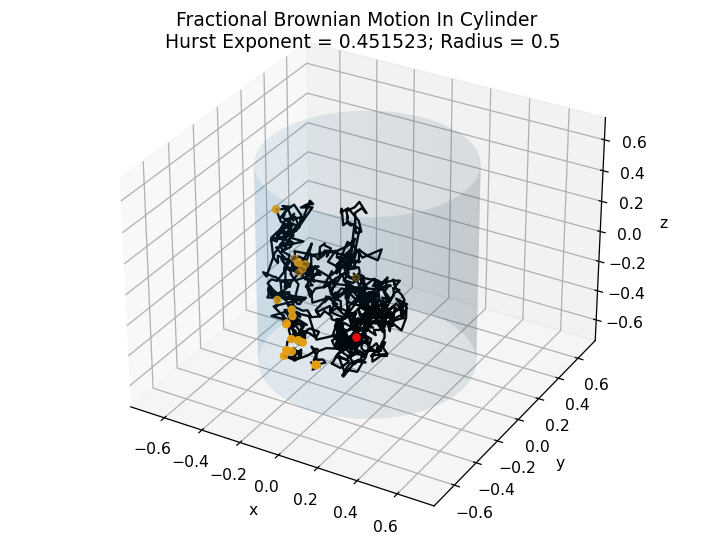

In [160]:
def plot_in_cylinder(r,nsteps,h = None,initial_pos=(0,0,0)):
    
    data_x, data_y, data_z, initial_pos_array,h_val = gen_fbm_track_collisions(r, nsteps,hurst_exp = h,initial_pos=initial_pos)

    fig = plt.figure()
    ax = Axes3D(fig)
    
    plot_random_walk_single(ax, data_x, data_y, data_z)
    plot_cylinder_along_z(ax,0, 0, r, 2*np.max(np.abs(data_z)))
    try:
        ax.scatter(xs=initial_pos_array[:,0], ys=initial_pos_array[:,1], zs=initial_pos_array[:,2], color='orange')
    except :IndexError
    
    plt.suptitle("Fractional Brownian Motion In Cylinder \n Hurst Exponent = {:f}; Radius = {}".format(h_val,r))

rand_pos_0 = get_rand_initial_pos_2(0.5)
plot_in_cylinder(0.5,1000,initial_pos=rand_pos_0)

In [241]:
def gen_mc_fbm_cylinder_data(radius, track_length, mc_samples,model_type,h_noise_amp=0.1):
    """
    Model type: const_h, stoch_h, const_h_refl
    """
    
    xyz_step_track_time_arr = np.empty((mc_samples*track_length, 7))

    for i in np.arange(mc_samples):
        
        track_id_arr = np.full((track_length,1),i)
        timestep_arr = np.arange(track_length)
        timestep_arr = np.reshape(timestep_arr,(track_length,1))
        timeabs_arr = 17.6*timestep_arr
        
        initial_position = get_rand_initial_pos_2(radius)
        
        if model_type=="const_h":
            x,y,z,_,h_val = gen_fbm_track_collisions(radius, track_length,hurst_exp = None,
                                                     initial_pos=initial_position)
            h_arr = np.full((track_length,1),h_val)
        elif model_type=="stoch_h":
            x,y,z,_,h_arr =gen_fbm_track_collisions_stoch_h(radius, track_length, h_noise_amp, lower_h_lim = 0.001,
                                                            upper_h_lim = 0.999, initial_pos=initial_position)
            h_arr = np.reshape(h_arr,(track_length,1))
            
        x = np.reshape(x,(track_length,1))
        y = np.reshape(y,(track_length,1))
        z = np.reshape(z,(track_length,1))
        
        xyz_step_track_time_arr[i*track_length:(i+1)*track_length,:] = np.hstack((x,y,z,timestep_arr,
                                                                                  track_id_arr,timeabs_arr,h_arr))
    
    header_arr = ["Position X","Position Y","Position Z","Time","TrackID","Absolute T","Simulated Hurst"]
 
    xyz_step_track_time_df = pd.DataFrame(xyz_step_track_time_arr, columns = header_arr)
    
    return xyz_step_track_time_df

def save_to_csv(track_df,radius,track_length,mc_samples,model_type,h_noise_amp=None,folder_path=None):
    """
    Model type: const_h, stoch_h, const_h_refl
    """
    if model_type == "const_h":
        filename = "{}_r{}_l{}_mc{}_cylinder_data.csv".format(model_type,radius,
                                                              track_length,mc_samples)
    elif model_type == "stoch_h":
        filename = "{}_hna{}_r{}_l{}_mc{}_cylinder_data.csv".format(model_type,h_noise_amp,radius,
                                                              track_length,mc_samples)
        
    if folder_path!=None:
        filename = folder_path + filename
        
    track_df.to_csv(filename,index=False)
    
def gen_mc_fbm_cylinder_csv(radius,track_length,mc_samples,model_type,h_noise_amplitude=0.1,folder_path=None):
    """
    Model type: const_h, stoch_h, const_h_refl
    """
    xyz_step_track_time_df = gen_mc_fbm_cylinder_data(radius,track_length,mc_samples,
                                                      model_type,h_noise_amp=h_noise_amplitude)
    
    save_to_csv(xyz_step_track_time_df,radius,track_length,mc_samples,
                model_type,h_noise_amp=h_noise_amplitude,folder_path=folder_path)
    
    return xyz_step_track_time_df
    

In [244]:
df = gen_mc_fbm_cylinder_csv(0.5,100,100,"const_h",folder_path="sim_haemocyte_pipe_data/const_h/")

In [245]:
df

,Position X,Position Y,Position Z,Time,TrackID,Absolute T,Simulated Hurst
0,0.103669,0.480406,-0.297140,0.0,0.0,0.0,0.832348
1,0.103669,0.480406,-0.297140,1.0,0.0,17.6,0.832348
2,0.083881,0.471154,-0.304046,2.0,0.0,35.2,0.832348
3,0.083881,0.471154,-0.304046,3.0,0.0,52.8,0.832348
4,0.091089,0.473968,-0.331332,4.0,0.0,70.4,0.832348
...,...,...,...,...,...,...,...
9995,0.465838,-0.083505,1.214171,95.0,99.0,1672.0,0.823962
9996,0.464269,-0.057966,1.233771,96.0,99.0,1689.6,0.823962
9997,0.455578,-0.034055,1.227392,97.0,99.0,1707.2,0.823962
9998,0.453537,-0.039024,1.240746,98.0,99.0,1724.8,0.823962


## Stochastic Hurst Exponent

In [232]:
def crawling_h_uniform_dist(length, amplitude, abs_lower_lim, abs_upper_lim):
    
    h_arr = np.empty(length)
    h0 = np.random.uniform(abs_lower_lim,abs_upper_lim)
    h_arr[0] = h0
    
    for i in np.arange(length-1):
        
        lower_lim,upper_lim = gen_lims(h_arr[i],amplitude,abs_lower_lim,abs_upper_lim)

        h_arr[i+1] = np.random.uniform(lower_lim,upper_lim)
    
    return h_arr

def gen_lims(centre,amplitude,absolute_lower_lim,absolute_upper_lim):
    
    temp_ll = centre - amplitude/2
    temp_ul = centre + amplitude/2
    
    if temp_ll < absolute_lower_lim:
        
        ll = absolute_lower_lim
        ul = temp_ul + abs(temp_ll-absolute_lower_lim)
    
    elif temp_ul > absolute_upper_lim:
        
        ll = temp_ll - abs(temp_ul-absolute_upper_lim)
        ul = absolute_upper_lim
        
    else:
        
        ll = temp_ll
        ul = temp_ul
        
    return ll,ul
    
stoch_h = crawling_h_uniform_dist(100,0.05,0.001,0.999)  

<IPython.core.display.Javascript object>


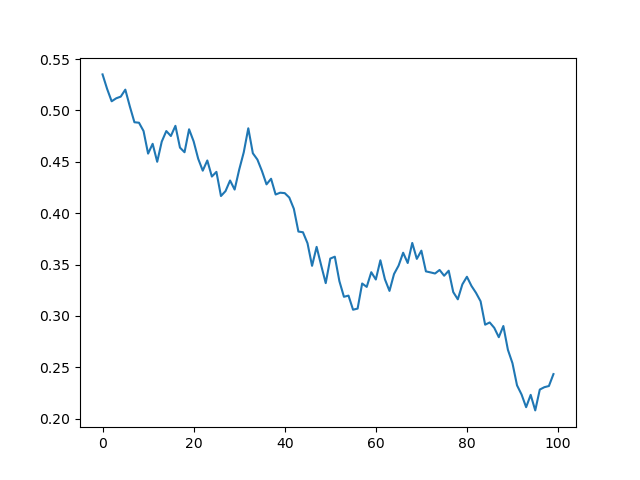

In [233]:
fig,ax = plt.subplots()
plt.plot(np.arange(len(stoch_h)),stoch_h)
plt.show()

In [235]:
def gen_fbm_track_collisions_stoch_h(radius, ntimes, h_noise_amp, lower_h_lim = 0.001,
                                     upper_h_lim = 0.999, initial_pos=(0,0,0)):
    
    input_hurst_arr = crawling_h_uniform_dist(ntimes, h_noise_amp, lower_h_lim, upper_h_lim)
    
    data_x, data_y, data_z = gen_fbm_track(ntimes, input_hurst_arr[0], initial_pos)
    data_x, data_y, data_z = track_until_reflection(data_x, data_y, data_z, radius)
    initial_pos_array = initial_pos
    
    output_hurst_arr = np.full((1,len(data_x)),input_hurst_arr[0])

    i = 1
    while len(data_x) < ntimes:
        
        new_initial_pos = (data_x[-1], data_y[-1], data_z[-1])
        initial_pos_array = np.vstack((initial_pos_array, new_initial_pos))
        
        x, y, z = gen_fbm_track(ntimes, input_hurst_arr[i], initial_position=new_initial_pos)
        
        new_x = np.append(data_x, x)
        new_y = np.append(data_y, y)
        new_z = np.append(data_z, z)
        
        temp_x,temp_y,temp_z = track_until_reflection(new_x, new_y, new_z, radius)
        """
        print("data_x = {}".format(data_x[-1]),"temp_x={}".format(temp_x[-1]))
        """
        if temp_x[-1]!=data_x[-1]:
                               
            new_hs = np.full((1,len(temp_x)-len(data_x)),input_hurst_arr[i])
            output_hurst_arr = np.append(output_hurst_arr, new_hs)
            data_x, data_y, data_z = temp_x,temp_y,temp_z
        
        i += 1
        
    data_x, data_y, data_z = data_x[:ntimes], data_y[:ntimes], data_z[:ntimes]
    output_hurst_arr = output_hurst_arr[:ntimes]
    return data_x, data_y, data_z, initial_pos_array, output_hurst_arr

def plot_in_cylinder(r,nsteps,model_type,h = None,h_noise_amp = 0.1,initial_pos=None):
    
            
    fig = plt.figure()
    ax = Axes3D(fig)
    
    if initial_pos==None:
        initial_pos = get_rand_initial_pos_2(r)
    
    if model_type == "const_h":
        
        data_x, data_y, data_z, initial_pos_array,h_val = gen_fbm_track_collisions(r, nsteps,hurst_exp = h,
                                                                                   initial_pos=initial_pos)
        plot_random_walk_single(ax, data_x, data_y, data_z)
        plt.suptitle("Fractional Brownian Motion In Cylinder \n Hurst Exponent = {:f}; Radius = {}".format(h_val,r))
        output = (data_x, data_y, data_z, initial_pos_array,h_val)
    elif model_type == "stoch_h":
        
        data_x, data_y, data_z,initial_pos_array,h_arr = gen_fbm_track_collisions_stoch_h(r, nsteps, h_noise_amp,
                                                                                          lower_h_lim=0.001, upper_h_lim=0.999,
                                                                                          initial_pos=initial_pos)
        plot_random_walk_single(ax, data_x, data_y, data_z)#,c_line=h_arr,cmap_line='inferno')
        plt.suptitle("Fractional Brownian Motion In Cylinder \n Stochastic Hurst Exponent; Radius = {}".format(r))
        #fig.colorbar(label='Hurst Exponent')
        output = (data_x, data_y, data_z,initial_pos_array,h_arr)
         
    
    plot_cylinder_along_z(ax,0, 0, r, 2*np.max(np.abs(data_z)))
    try:
        ax.scatter(xs=initial_pos_array[:,0], ys=initial_pos_array[:,1], zs=initial_pos_array[:,2], color='orange')
    except :IndexError
        
    return output

    

<IPython.core.display.Javascript object>


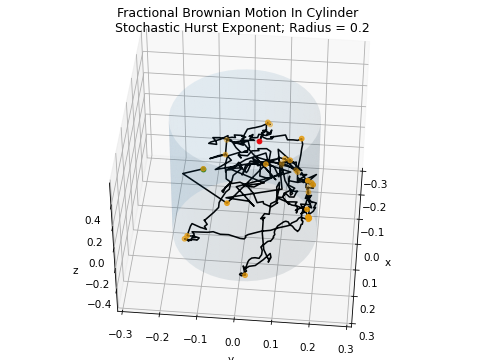

<IPython.core.display.Javascript object>


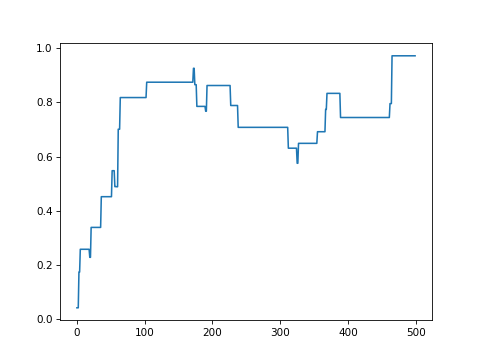

In [266]:
x,y,z,init_pos_arr,h_arr = plot_in_cylinder(0.2,500,"stoch_h",h_noise_amp = 0.25)

fig = plt.figure()
plt.plot(h_arr)
plt.show()



In [246]:
df_stoch = gen_mc_fbm_cylinder_csv(0.5,100,1000,"stoch_h",h_noise_amplitude=0.1,folder_path="sim_haemocyte_pipe_data/stoch_h/")

In [247]:
df_stoch

,Position X,Position Y,Position Z,Time,TrackID,Absolute T,Simulated Hurst
0,0.367227,0.304338,0.197413,0.0,0.0,0.0,0.542039
1,0.368974,0.230058,0.122316,1.0,0.0,17.6,0.542039
2,0.364391,0.257018,0.107039,2.0,0.0,35.2,0.542039
3,0.310230,0.207551,0.069018,3.0,0.0,52.8,0.542039
4,0.355027,0.236723,0.086230,4.0,0.0,70.4,0.542039
...,...,...,...,...,...,...,...
9995,-0.124949,-0.048101,1.506255,95.0,99.0,1672.0,0.927148
9996,-0.129154,-0.036509,1.549934,96.0,99.0,1689.6,0.927148
9997,-0.131508,-0.023752,1.550281,97.0,99.0,1707.2,0.927148
9998,-0.137199,-0.013839,1.555275,98.0,99.0,1724.8,0.927148


In [271]:
def gen_data_different_radii(r_lower,r_upper,r_step,track_length,mc_steps,model_type,
                             h_noise_amplitude=0.1,folder_path="sim_haemocyte_pipe_data/stoch_h/"):
    
    radii = np.arange(r_lower,r_upper,r_step)
    
    for i, r in enumerate(radii):
        
        gen_mc_fbm_cylinder_csv(r,track_length,mc_steps,model_type,
                                h_noise_amplitude=h_noise_amplitude,
                                folder_path=folder_path)


In [272]:
gen_data_different_radii(0.4,1.0,0.1,100,1000,"stoch_h",
                         h_noise_amplitude=0.1,folder_path="sim_haemocyte_pipe_data/stoch_h/")

ValueError: cannot reshape array of size 101 into shape (100,1)

In [256]:
np.linspace(0.2,1.4,7)

array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4])

## H(t) work

In [40]:
def h_sine(t):
    
    h_val = 0.5+0.4*np.sin(2*np.pi*t)
    
    return h_val

def h_step(t):
    
    print(max(t))
    
    h_val = np.piecewise(t, [t < max(t)//2, t >= max(t)//2], 
                         [lambda t: (t)//max(t), lambda t: 1-t//max(t)])

    return h_val
 
#m = mbm(n=1000, hurst=h_step, length=100, method='riemannliouville')
t = times(n=1000,length=100)

In [ ]:
#plt.plot(t,m)
plt.plot(t,h_step(t))

def gen_fbm_data(nsamples, ntimes, hurst_const=None):
    """ 
    Function to produce fractional brownian motion data for neural network 
    training and testing
    Inputs: nsamples; number of samples, ntimes; number of times (= number of steps)
    Outputs: traindata; training data for NN, trainlabels; labels associated 
            with traindata
    """
    #data = np.empty((nsamples,ntimes+1,3))
    data_x = np.empty((nsamples,ntimes+1))
    data_y = np.empty((nsamples,ntimes+1))
    data_z = np.empty((nsamples,ntimes+1))
                              
    labels = np.empty((nsamples,1))
    for i in range(0,nsamples):
        if hurst_const == None:
            hurst_exp = np.random.uniform(0.,1.)
        else:
            hurst_exp = hurst_const
        fbm = FractionalBrownianMotion(hurst=hurst_exp,t=1,rng=None)
        x = fbm.sample(ntimes)
        y = fbm.sample(ntimes)
        z = fbm.sample(ntimes)
        #apply differencing and normalization on the data
        #dx = (x[1:]-x[0:-1])/(np.amax(x)-np.amin(x))
        #dy = (y[1:]-x[0:-1])/(np.amax(y)-np.amin(y))
        #dz = (z[1:]-x[0:-1])/(np.amax(z)-np.amin(z))
        #data[i,:] = np.array([x,y,z]).transpose()
        data_x[i,:] = x
        data_y[i,:] = y
        data_z[i,:] = z
        labels[i,:] = hurst_exp
        
    return data_x, data_y, data_z, labels


In [82]:
np.random.uniform(0,1)

0.24280042502059573